# Projeto - Mineração de Texto e Web
## Residência Engenharia e Ciência de dados - Samsung/UFPE

### Lucas Couri - lncc2
### Mariama Oliveira - mcso

## Carregando Dados

In [1]:
#Imports
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score

import numpy as np
import tensorflow as tf
#from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [2]:
df = pd.read_csv("reviews_v2.csv")
df = df[df["reviews"].notna()]

In [3]:
df.head()


,reviews,stars,dates
0,Estou aqui para relatar uma experiência que ...,5,2021-06-05
1,"Já havia comprado a versão Lite, o que já ac...",5,2021-05-07
2,"Bom. Bem fluído, interessante e eficaz em cu...",5,2021-05-07
3,"Estou bem chateado, ja possuía o modelo anti...",3,2021-05-09
4,"Aparelho muito bom, está lidando muito bem c...",4,2021-05-06


In [4]:
df.dtypes

reviews    object
stars       int64
dates      object
dtype: object

## Pré-processamento (com e sem stemming)

In [3]:
#Global variables
other_punctuation = '—“”'  
stop_words = stopwords.words('portuguese')
stop_words.append('’')
stemmer = nltk.stem.RSLPStemmer()


#Function that removes punctuation 
def remove_punctuation(text):
    punctuation_free_doc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuation_free_doc


def remove_stopwords(list_words):
    filtered_words = [word for word in list_words if word not in stop_words]
    return filtered_words


def do_stemming(list_words):
    stem_text = [stemmer.stem(word) for word in list_words]
    return stem_text


def pre_process(doc, basic_processing = False, no_stopwords = False, stemming = False):

    final_doc = doc
    
    ## print(final_doc)

    if basic_processing == True:
        
        final_doc = remove_punctuation(doc)
        final_doc = final_doc.lower()

    final_doc = nltk.word_tokenize(final_doc)

    if no_stopwords == True:
        final_doc = remove_stopwords(final_doc)    

    if stemming == True:
        final_doc = do_stemming(final_doc)

    return final_doc

def pre_process_all(df, pre_processing_list):

    for param, index in zip(pre_processing_list, range(len(pre_processing_list))):
        
        df[f"reviews_pipeline_{index}"] = df["reviews"].apply(lambda x: pre_process(x, **param))

    return df

pre_processing_list = [
    {"basic_processing": True, "no_stopwords": True, "stemming": False},
    {"basic_processing": True, "no_stopwords": True, "stemming": True}]

df_pp = pre_process_all(df, pre_processing_list)

In [6]:
df_pp.head()

,reviews,stars,dates,reviews_pipeline_0,reviews_pipeline_1
0,Estou aqui para relatar uma experiência que ...,5,2021-06-05,"[aqui, relatar, experiência, visando, contribu...","[aqu, relat, experi, vis, contribu, amig, prob..."
1,"Já havia comprado a versão Lite, o que já ac...",5,2021-05-07,"[havia, comprado, versão, lite, achei, maravil...","[hav, compr, vers, lit, ach, maravilh, porém, ..."
2,"Bom. Bem fluído, interessante e eficaz em cu...",5,2021-05-07,"[bom, bem, fluído, interessante, eficaz, cumpr...","[bom, bem, flu, interess, eficaz, cumpr, prome..."
3,"Estou bem chateado, ja possuía o modelo anti...",3,2021-05-09,"[bem, chateado, ja, possuía, modelo, antigo, b...","[bem, chate, ja, possuí, model, antig, bem, co..."
4,"Aparelho muito bom, está lidando muito bem c...",4,2021-05-06,"[aparelho, bom, lidando, bem, home, tv, apenas...","[aparelh, bom, lid, bem, hom, tv, apen, porém,..."


In [7]:
df_pp[["reviews_pipeline_0", "reviews_pipeline_1"]]

,reviews_pipeline_0,reviews_pipeline_1
0,"[aqui, relatar, experiência, visando, contribu...","[aqu, relat, experi, vis, contribu, amig, prob..."
1,"[havia, comprado, versão, lite, achei, maravil...","[hav, compr, vers, lit, ach, maravilh, porém, ..."
2,"[bom, bem, fluído, interessante, eficaz, cumpr...","[bom, bem, flu, interess, eficaz, cumpr, prome..."
3,"[bem, chateado, ja, possuía, modelo, antigo, b...","[bem, chate, ja, possuí, model, antig, bem, co..."
4,"[aparelho, bom, lidando, bem, home, tv, apenas...","[aparelh, bom, lid, bem, hom, tv, apen, porém,..."
...,...,...
5002,"[chegou, super, rápido, atendeu, superou, toda...","[cheg, sup, rápid, atend, super, tod, expect]"
5003,"[facil, instalação, configuração, entrega, sup...","[facil, instal, configur, entreg, sup, rápid]"
5004,"[amei, produto, unico, problema, pra, mim, nao...","[ame, produt, unic, problem, pra, mim, nao, hbo]"
5005,"[funciona, beleza, rede, internet, sendo, boa,...","[func, bel, red, internet, send, boa, tud, bem]"


## Definindo classe

In [4]:
df_pp["class"] = df_pp["stars"].apply(lambda x : 1 if x >=4 else 0)

## Divisão train e test

In [5]:
X = df_pp[["reviews_pipeline_0", "reviews_pipeline_1"]]
y = df_pp["class"]
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.3, random_state = 42, stratify=y_train_valid)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [11]:
X_train.head()

,reviews_pipeline_0,reviews_pipeline_1
877,"[fácil, acesso, mto, bom, porém, comprei, vers...","[fácil, acess, mto, bom, porém, compr, vers, c..."
3525,"[prática, tv, inteligente, completa, melhor]","[prát, tv, intelig, complet, melhor]"
3941,"[produto, funciona, bem, faltou, controle, par...","[produt, func, bem, falt, control, parametr, t..."
1468,"[produto, perfeito, medo, comprar, pq, dissera...","[produt, perfeit, med, compr, pq, diss, q, pou..."
819,"[aplicativo, jr, play, funciona, tentar, baixa...","[aplic, jr, play, func, tent, baix, instal, ap..."


Transformando tokens em string

In [6]:
X_train_join = []
X_train_join.append(X_train["reviews_pipeline_0"].apply(" ".join))
X_train_join.append(X_train["reviews_pipeline_1"].apply(" ".join))
X_train_join[0] = X_train_join[0].to_numpy()
X_train_join[1] = X_train_join[1].to_numpy()

X_test_join = []
X_test_join.append(X_test["reviews_pipeline_0"].apply(" ".join))
X_test_join.append(X_test["reviews_pipeline_1"].apply(" ".join))
X_test_join[0] = X_test_join[0].to_numpy()
X_test_join[1] = X_test_join[1].to_numpy()

X_valid_join = []
X_valid_join.append(X_valid["reviews_pipeline_0"].apply(" ".join))
X_valid_join.append(X_valid["reviews_pipeline_1"].apply(" ".join))
X_valid_join[0] = X_valid_join[0].to_numpy()
X_valid_join[1] = X_valid_join[1].to_numpy()



# Classificadores 

## Random Forest com BoW

In [13]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

#List with BoWs (pipeline 0 and 1)
X_train_vec = []
X_train_vec.append(vectorizer.fit_transform(X_train_join[0]))
X_train_vec.append(vectorizer.fit_transform(X_train_join[1]))

X_test_vec = []
X_test_vec.append(vectorizer.fit_transform(X_test_join[0]))
X_test_vec.append(vectorizer.fit_transform(X_test_join[1]))

X_valid_vec = []
X_valid_vec.append(vectorizer.fit_transform(X_valid_join[0]))
X_valid_vec.append(vectorizer.fit_transform(X_valid_join[1]))


print(X_train_vec[0].shape)

(2451, 2000)


### Sem stemming

In [ ]:
cv = model_selection.StratifiedKFold(n_splits=10)

In [ ]:
def val_rf(X_train, y_train, parameters, cv, SEED):

    rf = RandomForestClassifier(random_state = SEED)

    search = GridSearchCV(rf,
                          parameters,
                          scoring = "accuracy",
                          n_jobs = -1,
                          cv = cv)

    result_rf = search.fit(X_train, y_train)
    
    print('=========Resultados do Grid Search para Random Forest==========')
    print(f'Melhor Score: {result_rf.best_score_}')
    print(f'Melhores Hiperparâmetros: {result_rf.best_params_}')

    return result_rf

parameters = dict()
parameters['n_estimators'] = range(10, 301, 20)
parameters['criterion'] = ["gini", "entropy"]
parameters['max_features'] = ["auto", "sqrt", "log2"]
parameters['min_samples_leaf'] = [1, 4]
parameters['min_samples_split'] = [2, 10]
parameters['max_depth'] = [10, 100, None]#[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

result_rf_1 = val_rf(X_train, y_train, parameters, cv, SEED)

In [14]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train_vec[0], y_train)

In [15]:
predictions = forest.predict(X_test_vec[0]) 
result = forest.predict(X_test_vec[0])
print(classification_report(y_test, result))


              precision    recall  f1-score   support

           0       0.20      0.10      0.13       167
           1       0.89      0.95      0.92      1334

    accuracy                           0.85      1501
   macro avg       0.55      0.53      0.53      1501
weighted avg       0.82      0.85      0.83      1501



Matriz de Confusão

In [16]:
confusion_matrix(y_test, result)

array([[  17,  150],
       [  69, 1265]], dtype=int64)

### Com Stemming

In [17]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train_vec[1], y_train)

In [18]:
predictions = forest.predict(X_test_vec[1]) 
result = forest.predict(X_test_vec[1])
print(classification_report(y_test, result))


              precision    recall  f1-score   support

           0       0.18      0.14      0.16       167
           1       0.90      0.92      0.91      1334

    accuracy                           0.84      1501
   macro avg       0.54      0.53      0.53      1501
weighted avg       0.82      0.84      0.83      1501



In [19]:
confusion_matrix(y_test, result)

array([[  23,  144],
       [ 103, 1231]], dtype=int64)

## Redes (CNN, LSTM e BERT)

In [19]:
# tf.keras.layers.TextVectorization(
#     max_tokens=None,
#     standardize='lower_and_strip_punctuation',
#     split='whitespace',
#     ngrams=None,
#     output_mode='int',
#     output_sequence_length=None,
#     pad_to_max_tokens=False,
#     vocabulary=None,
#     idf_weights=None,
#     sparse=False,
#     ragged=False,
#     **kwargs
# )

In [20]:
X_train_join[0]

array(['chegou antes prazo mostrou excelente produto vale compra',
       'melhor produto comprei pra tv igual funciona bem',
       'gostei falta globoplay pra mim único defeito momento', ...,
       'atendeu todas expectativas ótimo produto fácil instalação controle prático funciona perfeitamente',
       'funcionou tv sansung usar tv smart atendeu',
       'comprei pra dar upgrade tv ameinão fácil instalar tudo intuitivo rápidoestou amando'],
      dtype=object)

### Encoder (Sem stemming)

In [7]:
VOCAB_SIZE = 1000
encoder_0 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize=None
                                            )
#encoder.adapt(train_dataset.map(lambda text, label: text))
encoder_0.adapt(X_train_join[0])


In [8]:
vectorized_text = encoder_0(X_train_join[0])
print(vectorized_text)

tf.Tensor(
[[  5  96 519 ...   0   0   0]
 [514   2 523 ...   0   0   0]
 [  3  16   6 ...   0   0   0]
 ...
 [198   1   2 ...   0   0   0]
 [ 49  28 467 ...   0   0   0]
 [ 38 274   2 ...   0   0   0]], shape=(2451, 180), dtype=int64)


In [9]:
vocab = np.array(encoder_0.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tv', 'produto', 'controle', 'fácil', 'bem', 'alexa',
       'fire', 'bom', 'instalar', 'stick', 'hbo', 'aparelho', 'amazon',
       'smart', 'funciona', 'tudo', 'excelente', 'recomendo'],
      dtype='<U17')

### Encoder (Com stemming)

In [10]:
VOCAB_SIZE = 1000
encoder_1 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize=None
                                            )
#encoder.adapt(train_dataset.map(lambda text, label: text))
encoder_1.adapt(X_train_join[1])


In [11]:
vectorized_text = encoder_1(X_train_join[1])
print(vectorized_text)

tf.Tensor(
[[  6  67 488 ...   0   0   0]
 [ 84   2 366 ...   0   0   0]
 [  3  21   7 ...   0   0   0]
 ...
 [199 851   2 ...   0   0   0]
 [ 46  37 383 ...   0   0   0]
 [  9 185   2 ...   0   0   0]], shape=(2451, 180), dtype=int64)


In [12]:
vocab = np.array(encoder_1.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tv', 'produt', 'control', 'instal', 'fácil', 'bem',
       'alex', 'compr', 'fir', 'bom', 'app', 'stick', 'ótim', 'rápid',
       'tod', 'aplic', 'aparelh', 'funcion'], dtype='<U12')

### CNN

#### Sem stemming

In [13]:
import keras_tuner as kt
##Testando keras tuner

def model_builder_0(hp):

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model_CNN_0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    #tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(units=hp_units, activation='relu'), #>>>>>Hiperparametro
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_CNN_0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), #>>>>>Hiperparametro
              metrics=['accuracy'])

    return model_CNN_0

In [189]:
# model_CNN_0 = tf.keras.Sequential([
#     encoder_0,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder_0.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     #tf.keras.layers.Flatten(),    
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
# print(model_CNN_0.summary())

In [190]:
# model_CNN_0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [ ]:
# history = model_CNN_0.fit(X_train_join[0], y_train, epochs=30,
#                     batch_size = 32,
#                     validation_data= (X_valid_join[0], y_valid),
#                     validation_steps=30
#                     )

In [14]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder_0, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='tuner', # directory to save logs 
project_name='cnn_0')

In [15]:
# hypertuning settings
tuner.search_space_summary() 


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_join[1], y_train, epochs=10, validation_data = (X_valid_join[0], y_valid), callbacks=[stop_early])
best_hp = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.8915318846702576

Best val_accuracy So Far: 0.8915318846702576
Total elapsed time: 00h 03m 01s
INFO:tensorflow:Oracle triggered exit


In [17]:
# Build the model with the optimal hyperparameters
model_CNN_0 = tuner.hypermodel.build(best_hp)
model_CNN_0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 192)         6336      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 192)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
history = model_CNN_0.fit(X_train_join[0], y_train, epochs=10, validation_data = (X_valid_join[0], y_valid))

Epoch 1/10
74/77 [===========================>..] - ETA: 0s - loss: 0.4142 - accuracy: 0.8830

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - 2s 16ms/step - loss: 0.4094 - accuracy: 0.8841 - val_loss: 0.3360 - val_accuracy: 0.8887
Epoch 2/10
77/77 [==============================] - 1s 12ms/step - loss: 0.3028 - accuracy: 0.8890 - val_loss: 0.2918 - val_accuracy: 0.8887
Epoch 3/10
77/77 [==============================] - 1s 13ms/step - loss: 0.2161 - accuracy: 0.9021 - val_loss: 0.2607 - val_accuracy: 0.9068
Epoch 4/10
77/77 [==============================] - 1s 13ms/step - loss: 0.1444 - accuracy: 0.9417 - val_loss: 0.2766 - val_accuracy: 0.9010
Epoch 5/10
77/77 [==============================] - 1s 13ms/step - loss: 0.0857 - accuracy: 0.9702 - val_loss: 0.3203 - val_accuracy: 0.8963
Epoch 6/10
77/77 [==============================] - 1s 15ms/step - loss: 0.0468 - accuracy: 0.9894 - val_loss: 0.3524 - val_accuracy: 0.8915
Epoch 7/10
77/77 [==============================] - 1s 13ms/step - loss: 0.0221 - accuracy: 0.9951 - val_loss: 0.4094 - val_accuracy: 0.8877
Epoch 8/10
77/77 [======

In [19]:
test_loss, test_acc = model_CNN_0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 28ms/step - loss: 0.6830 - accuracy: 0.8894
Test Loss: 0.6829746961593628
Test Accuracy: 0.8894070386886597


In [20]:
result = model_CNN_0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.51      0.29      0.37       167
           1       0.92      0.96      0.94      1334

    accuracy                           0.89      1501
   macro avg       0.71      0.63      0.65      1501
weighted avg       0.87      0.89      0.88      1501



In [21]:
confusion_matrix(y_test, result)

array([[  48,  119],
       [  47, 1287]], dtype=int64)

(0.0, 0.6301576284458861)

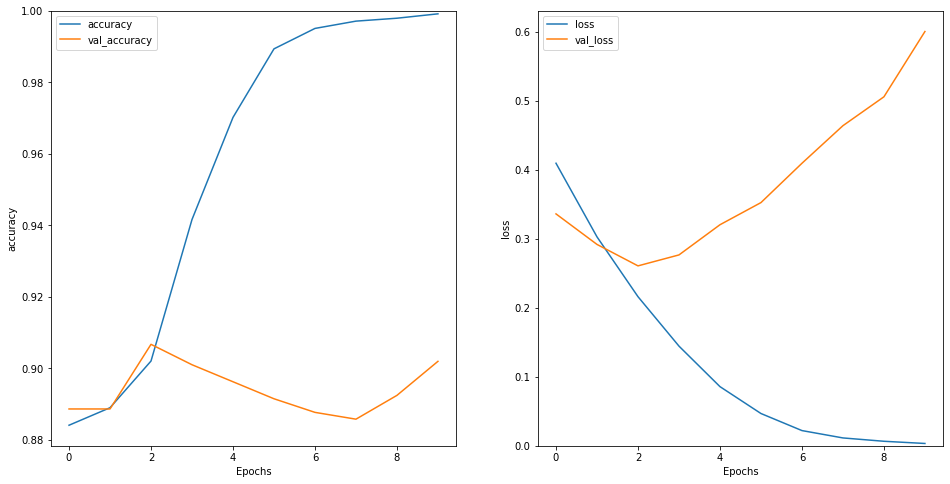

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [196]:
# model_CNN_1 = tf.keras.Sequential([
#     encoder_1,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder_1.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     #tf.keras.layers.Flatten(),    
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.GlobalMaxPool1D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [23]:
import keras_tuner as kt
##Testando keras tuner

def model_builder_1(hp):

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model_CNN_1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    #tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(units=hp_units, activation='relu'), #>>>>>Hiperparametro
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_CNN_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), #>>>>>Hiperparametro
              metrics=['accuracy'])

    return model_CNN_1

In [24]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder_1, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='tuner', # directory to save logs 
project_name='cnn_1')

In [25]:
# hypertuning settings
tuner.search_space_summary() 


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [26]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train_join[1], y_train, epochs=10, validation_data = (X_valid_join[1], y_valid), callbacks=[stop_early])

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.9105613827705383

Best val_accuracy So Far: 0.9105613827705383
Total elapsed time: 00h 02m 44s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_hp = tuner.get_best_hyperparameters()[0]

In [35]:
# Build the model with the optimal hyperparameters
model_CNN_1 = tuner.hypermodel.build(best_hp)
model_CNN_1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [38]:
history = model_CNN_1.fit(X_train_join[1], y_train, epochs=10, validation_data = (X_valid_join[1], y_valid))

Epoch 1/10


C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8809

C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


77/77 [==============================] - 2s 17ms/step - loss: 0.3299 - accuracy: 0.8809 - val_loss: 0.2553 - val_accuracy: 0.9029
Epoch 2/10
77/77 [==============================] - 1s 11ms/step - loss: 0.1948 - accuracy: 0.9213 - val_loss: 0.3198 - val_accuracy: 0.8991
Epoch 3/10
77/77 [==============================] - 1s 14ms/step - loss: 0.0932 - accuracy: 0.9661 - val_loss: 0.3441 - val_accuracy: 0.8792
Epoch 4/10
77/77 [==============================] - 1s 12ms/step - loss: 0.0496 - accuracy: 0.9841 - val_loss: 0.3971 - val_accuracy: 0.8763
Epoch 5/10
77/77 [==============================] - 1s 13ms/step - loss: 0.0520 - accuracy: 0.9825 - val_loss: 0.5674 - val_accuracy: 0.9049
Epoch 6/10
77/77 [==============================] - 1s 12ms/step - loss: 0.0398 - accuracy: 0.9894 - val_loss: 0.6047 - val_accuracy: 0.8972
Epoch 7/10
77/77 [==============================] - 1s 10ms/step - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.6603 - val_accuracy: 0.9068
Epoch 8/10
77/77 [======

In [ ]:
# print(model_CNN_1.summary())

In [198]:
# model_CNN_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [ ]:
# history = model_CNN_1.fit(X_train_join[1], y_train, epochs=20,
#                     batch_size = 32,
#                     validation_data= (X_valid_join[1], y_valid),
#                     validation_steps=3
#                     )

In [39]:
#test_loss, test_acc = model_CNN_1.evaluate(X_test_join[1], y_test)
test_loss, test_acc = model_CNN_1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 29ms/step - loss: 0.9656 - accuracy: 0.8728
Test Loss: 0.9656330347061157
Test Accuracy: 0.8727514743804932


In [40]:
result = h_model.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))


              precision    recall  f1-score   support

           0       0.40      0.29      0.33       167
           1       0.91      0.95      0.93      1334

    accuracy                           0.87      1501
   macro avg       0.66      0.62      0.63      1501
weighted avg       0.86      0.87      0.86      1501



In [41]:
confusion_matrix(y_test, result)

array([[  48,  119],
       [  72, 1262]], dtype=int64)

NameError: name 'history' is not defined

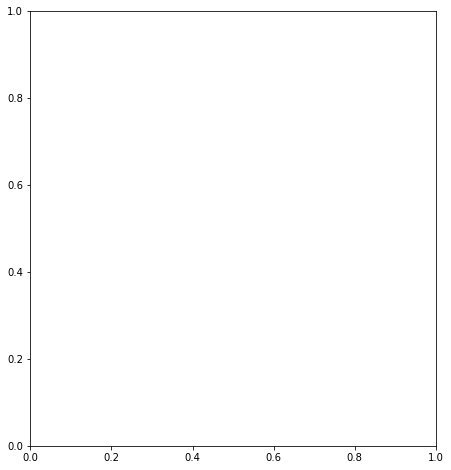

In [42]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### LSTM

In [127]:
model_LSTM0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [128]:
model_LSTM0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [153]:
print(model_LSTM0.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_9 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

#### Sem stemming

Treinando modelo

In [129]:
history = model_LSTM0.fit(X_train_join[0], y_train, epochs=20,
                    batch_size = 32,
                    validation_data= (X_valid_join[0], y_valid),
                    validation_steps=30
                    )

Epoch 1/20


C:\Users\lucas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 17s 99ms/step - loss: 0.6236 - accuracy: 0.8607 - val_loss: 0.4794 - val_accuracy: 0.8854
Epoch 2/20
110/110 [==============================] - 8s 75ms/step - loss: 0.4170 - accuracy: 0.8898 - val_loss: 0.3741 - val_accuracy: 0.8854
Epoch 3/20
110/110 [==============================] - 8s 74ms/step - loss: 0.3380 - accuracy: 0.8898 - val_loss: 0.3239 - val_accuracy: 0.8854
Epoch 4/20
110/110 [==============================] - 8s 74ms/step - loss: 0.2951 - accuracy: 0.8898 - val_loss: 0.2898 - val_accuracy: 0.8854
Epoch 5/20
110/110 [==============================] - 8s 75ms/step - loss: 0.2576 - accuracy: 0.8926 - val_loss: 0.2571 - val_accuracy: 0.8906
Epoch 6/20
110/110 [==============================] - 9s 77ms/step - loss: 0.2229 - accuracy: 0.9063 - val_loss: 0.2471 - val_accuracy: 0.8938
Epoch 7/20
110/110 [==============================] - 9s 78ms/step - loss: 0.1973 - accuracy: 0.9258 - val_loss: 0.2418 - val_accuracy: 0.8979
Epoch 8/2

Avaliando modelo

In [134]:
test_loss, test_acc = model_LSTM0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 26ms/step - loss: 0.4435 - accuracy: 0.8854
Test Loss: 0.4434678554534912
Test Accuracy: 0.8854097127914429


In [135]:
result = model_LSTM0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.49      0.46      0.48       170
           1       0.93      0.94      0.94      1331

    accuracy                           0.89      1501
   macro avg       0.71      0.70      0.71      1501
weighted avg       0.88      0.89      0.88      1501



In [132]:
confusion_matrix(y_test, result)

array([[  78,   92],
       [  80, 1251]], dtype=int64)

(0.0, 0.6511498056352139)

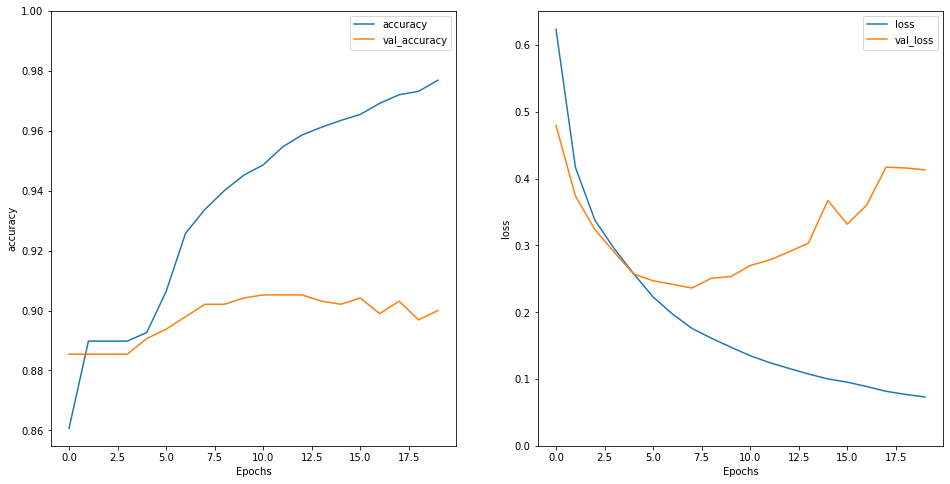

In [133]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [ ]:
model_LSTM1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_LSTM1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Treinando modelo

In [105]:
history = model_LSTM1.fit(X_train_join[1], y_train, epochs=10,
                    batch_size = 32,
                    validation_data= (X_valid_join[1], y_valid),
                    validation_steps=30
                    )

Epoch 1/10
110/110 [==============================] - 8s 72ms/step - loss: 0.2992 - accuracy: 0.8841 - val_loss: 0.3168 - val_accuracy: 0.8750
Epoch 2/10
110/110 [==============================] - 7s 66ms/step - loss: 0.2815 - accuracy: 0.8909 - val_loss: 0.3172 - val_accuracy: 0.8854
Epoch 3/10
110/110 [==============================] - 8s 70ms/step - loss: 0.2771 - accuracy: 0.8932 - val_loss: 0.3206 - val_accuracy: 0.8656
Epoch 4/10
110/110 [==============================] - 7s 65ms/step - loss: 0.2766 - accuracy: 0.8912 - val_loss: 0.3253 - val_accuracy: 0.8865
Epoch 5/10
110/110 [==============================] - 7s 65ms/step - loss: 0.2733 - accuracy: 0.8943 - val_loss: 0.3140 - val_accuracy: 0.8708
Epoch 6/10
110/110 [==============================] - 7s 65ms/step - loss: 0.2712 - accuracy: 0.8941 - val_loss: 0.3252 - val_accuracy: 0.8656
Epoch 7/10
110/110 [==============================] - 7s 67ms/step - loss: 0.2689 - accuracy: 0.8955 - val_loss: 0.3138 - val_accuracy: 0.8771

Avaliando modelo

In [106]:
test_loss, test_acc = model_LSTM1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 21ms/step - loss: 0.3092 - accuracy: 0.8761
Test Loss: 0.3092056214809418
Test Accuracy: 0.8760825991630554


In [107]:
result = model_LSTM1.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.37      0.14      0.20       170
           1       0.90      0.97      0.93      1331

    accuracy                           0.88      1501
   macro avg       0.63      0.55      0.57      1501
weighted avg       0.84      0.88      0.85      1501



In [108]:
confusion_matrix(y_test, result)

array([[  23,  147],
       [  39, 1292]], dtype=int64)

(0.0, 0.3284050300717354)

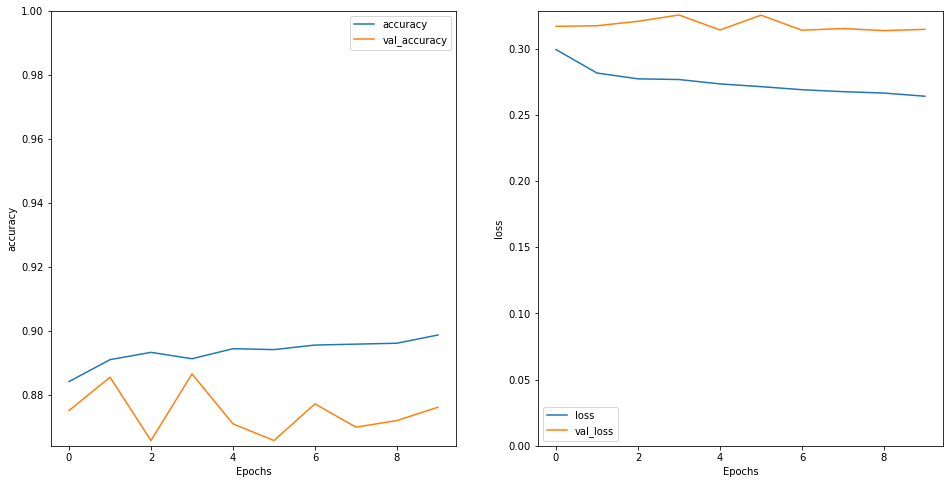

In [109]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### BERT

In [7]:
from transformers import BertTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

In [9]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [10]:
# can be up to 512 for BERT
max_length = 256
batch_size = 1

In [11]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [12]:
def encode_examples(texts, labels, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  # for review, label in tfds.as_numpy(ds):
  for text, label in zip(texts, labels):
    bert_input = convert_example_to_feature(text)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

#### Sem stemming

In [13]:
# train dataset
ds_train_encoded_0 = encode_examples(X_train_join[0], y_train).shuffle(3).batch(batch_size)

# test dataset
ds_test_encoded_0 = encode_examples(X_test_join[0], y_test).batch(batch_size)

#validation dataset
ds_valid_encoded_0 = encode_examples(X_valid_join[0], y_valid).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\mcso\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3
# model initialization
model_bert_0 = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert_0.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [16]:
bert_history = model_bert_0.fit(ds_train_encoded_0, epochs=number_of_epochs, validation_data=ds_valid_encoded_0)

Epoch 1/3
3502/3502 [==============================] - 1006s 282ms/step - loss: 0.2793 - accuracy: 0.8929 - val_loss: 0.2160 - val_accuracy: 0.9121
Epoch 2/3
3502/3502 [==============================] - 973s 278ms/step - loss: 0.2039 - accuracy: 0.9232 - val_loss: 0.2337 - val_accuracy: 0.9094
Epoch 3/3
3502/3502 [==============================] - 976s 279ms/step - loss: 0.1508 - accuracy: 0.9492 - val_loss: 0.2370 - val_accuracy: 0.9194


In [17]:
tf_output = model_bert_0.predict(ds_test_encoded_0)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label_pred = label.numpy()
print(label_pred)

[1 1 1 ... 1 1 1]


In [19]:
unique, counts = np.unique(label_pred, return_counts=True)
dict(zip(unique, counts))

{0: 85, 1: 1416}

In [20]:
print(classification_report(y_test, label_pred))

              precision    recall  f1-score   support

           0       0.79      0.39      0.53       170
           1       0.93      0.99      0.96      1331

    accuracy                           0.92      1501
   macro avg       0.86      0.69      0.74      1501
weighted avg       0.91      0.92      0.91      1501



In [21]:
confusion_matrix(y_test, label_pred)

array([[  67,  103],
       [  18, 1313]], dtype=int64)

#### Com stemming

In [ ]:
# train dataset
ds_train_encoded_1 = encode_examples(X_train_join[1], y_train).shuffle(3).batch(batch_size)

# test dataset
ds_test_encoded_1 = encode_examples(X_test_join[1], y_test).batch(batch_size)

#validation dataset
ds_valid_encoded_1 = encode_examples(X_valid_join[1], y_valid).batch(batch_size)

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3
# model initialization
model_bert_1 = TFBertForSequenceClassification.from_pretrained('bert-base-portuguese-cased', from_pt = True)

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_bert_1.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model_bert_1.fit(ds_train_encoded_1, epochs=number_of_epochs, validation_data=ds_valid_encoded_1)

In [ ]:
tf_output = model_bert_1.predict(ds_test_encoded_1)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label_pred = label.numpy()
print(label_pred)

In [ ]:
unique, counts = np.unique(label_pred, return_counts=True)
dict(zip(unique, counts))

In [ ]:
print(classification_report(y_test, label_pred))

In [ ]:
confusion_matrix(y_test, label_pred)